# Calculating fisher score in the training of the CNN

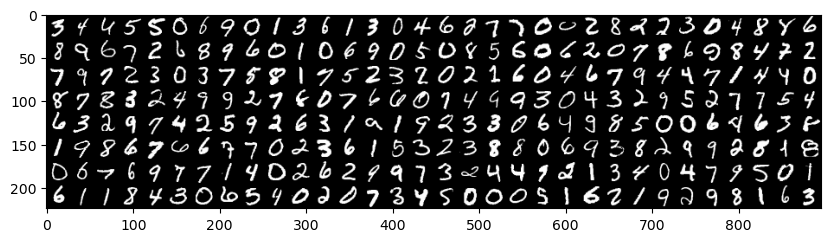

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

datadir = "./data"
batch_size = 256

transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(datadir, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_set = datasets.MNIST(datadir, train=False, download=True, transform=transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

tmp_loader = DataLoader(val_set, batch_size=3000, shuffle=True)
X_display, y_display = val_loader.__iter__().next()

X, y = train_loader.__iter__().next()
out = X.detach().numpy()
out = out.reshape(8, int(batch_size / 8),28,28)
out = out.transpose(0,2,1,3)
out = out.reshape(8*28,int(batch_size / 8)*28)
out = (out*(batch_size - 1)).astype(np.uint8)

plt.figure(figsize=(10, 5), dpi=100)
plt.imshow(out, "gray")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as f

class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()
        self.conv1 = nn.Conv2d(1,16,3,1)
        self.conv2 = nn.Conv2d(16,16,3,1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.dim_feature = 128
        self.fc1 = nn.Linear(12*12*16, self.dim_feature)
        self.fc2 = nn.Linear(self.dim_feature, 10)
        
        self._last_feature = None

    def forward(self,x):
        x = self.conv1(x)
        x = f.relu(x)
        x = self.conv2(x)
        x = f.relu(x)
        x = self.pool(x)
        x = x.view(-1, 12*12*16)
        x = self.fc1(x)
        x = torch.tanh(x)
                
        self._last_feature = x.detach()
        
        x = self.fc2(x)

        return f.log_softmax(x, dim=1)
    
    @property
    def last_feature(self):
        return self._last_feature.detach()
    
net = CNNmodel()
print(net)

CNNmodel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [3]:
#エポック数，バッジサイズ
epoch = 300

#学習結果の保存
history = {
    "train_loss": [],
    "validation_loss": [],
    "validation_acc": [],
    "fisher_score": [],
    "tr_b": [],
    "tr_w": [],
}

data_loader = {"train":train_loader, "validation":val_loader}

#GPUが使えるときは使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Fisher descriminant ratio

def fisher_descriminant_score():
    net.eval()
    
    n_class = len(set(val_set.targets.numpy()))
    n_for_each_class = {i: 0 for i in range(n_class)}

    mean_global = np.zeros(net.dim_feature)
    mean_c = np.zeros((n_class, net.dim_feature))
    
    s_c = np.zeros((n_class, net.dim_feature, net.dim_feature))
    s_W = np.zeros((net.dim_feature, net.dim_feature))
    s_B = np.zeros((net.dim_feature, net.dim_feature))

    with torch.no_grad():
        # Calculate global mean
        for data, target in data_loader["validation"]:
            data, target = data.to(device), target.to(device)

            #順伝搬の計算
            net(data)

            x = net.last_feature.numpy()

            for i in range(len(data)):
                mean_global += x[i]

                c = int(target.numpy()[i])
                x_c = x[i]

                mean_c[c] += x_c
                n_for_each_class[c] += 1        
                
    # get global mean
    n_all = np.sum(list(n_for_each_class.values()))
    mean_global /= n_all
        
    # get class mean
    for c in range(n_class):
        mean_c[c] /= n_for_each_class[c]

    # within-class scatter
    with torch.no_grad():
        for data, target in data_loader["validation"]:
            data, target = data.to(device), target.to(device)

            net(data)

            for i in range(len(data)):
                c = int(target[i].numpy())
                x_hat_c = net.last_feature[i].numpy()
                mu = np.atleast_2d(x_hat_c - mean_c[c])
                s = np.dot(mu, mu.transpose())
                s_c[c] += s

    s_W = np.sum(s_c, axis=0)

    # between-class scatter
    for c in range(n_class):
        mu = np.atleast_2d(mean_c[c] - mean_global)
        s = n_for_each_class[c] * np.dot(mu, mu.transpose())
        s_B += s

    # Fisher descriminant ratio-based score
    fisher_disc_ratio = np.dot(np.linalg.pinv(s_W), s_B)
    score = np.trace(fisher_disc_ratio)
        
    return score, np.trace(s_B), np.trace(s_W)

print("example (score, between_class_cov_tr, within_class_cov_tr): ", fisher_descriminant_score())

example (score, between_class_cov_tr, within_class_cov_tr):  (0.36086429870872594, 33653.564576339966, 93258.22669840699)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

fig = plt.figure(figsize=(5, 5), dpi=100)

lda = LinearDiscriminantAnalysis(n_components=2)

#ネットワーク構造の構築
net = CNNmodel().to(device)
print(net)

#最適化方法の設定
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

for e in range(epoch):
    print("\nValidation start:")
    net.eval() #検証モード(Validation)
    val_loss = 0.0
    accuracy = 0.0

    with torch.no_grad():
        for data,target in data_loader["validation"]:
            data,target = data.to(device),target.to(device)

            #順伝搬の計算
            output = net(data)
            loss = f.nll_loss(output,target).item()
            val_loss += f.nll_loss(output,target,reduction='sum').item()
            predict = output.argmax(dim=1,keepdim=True)
            accuracy += predict.eq(target.view_as(predict)).sum().item()

    val_loss /= len(data_loader["validation"].dataset)
    accuracy /= len(data_loader["validation"].dataset)

    print("Validation loss: {}, Accuracy: {}\n".format(val_loss,accuracy))
    history["validation_loss"].append(val_loss)
    history["validation_acc"].append(accuracy)
    
    # Fisher discriminant measure の計算：Zarka et al. 2020
    print("Fisher discrinimant measure start:")
    score, tr_b, tr_w = fisher_descriminant_score()
    history["fisher_score"].append(score)
    history["tr_w"].append(tr_w)
    history["tr_b"].append(tr_b)
    print(f"Fisher desctiminant score: {score}")
    print(f"within-class cov: {tr_w}, between-class cov: {tr_b}")
    
    # LDA projection
    net(X_display)

    x = net.last_feature.numpy()
            
    X_r = lda.fit(x, y_display).transform(x)
    
    cmap = plt.get_cmap("tab10")
    
    for i in range(10):
        plt.scatter(
            X_r[y_display == i, 0], X_r[y_display == i, 1], alpha=0.5, color=cmap(i), label=i
        )
    plt.legend([str(i) for i in range(10)], loc='upper right')
    plt.xlim([-20, 20])
    plt.ylim([-20, 20])
    fig.savefig(f"img_{e}.png")
    plt.axis("off")
    plt.clf()
    
    """ 学習部分 """
    loss = None
    train_loss = 0.0
    net.train() #学習モード
    print("\nTrain start")
    for i, (data, target) in enumerate(data_loader["train"]):
        data, target = data.to(device), target.to(device)
        
        #勾配の初期化
        optimizer.zero_grad()

        output = net(data)
        loss = f.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 5 == 4:
            print("Training: {} epoch. {} iteration. Loss:{}".format(e+1,i+1,loss.item()))
            break

    train_loss /= len(data_loader["train"])
    print("Training loss (ave.): {}".format(train_loss))
    history["train_loss"].append(train_loss)
    
    print("---")
    

CNNmodel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Validation start:
Validation loss: 2.3016142250061034, Accuracy: 0.0828

Fisher discrinimant measure start:
Fisher desctiminant score: 0.33170977302766225
within-class cov: 101225.20298398568, between-class cov: 33577.38910649704

Train start
Training: 1 epoch. 5 iteration. Loss:2.046326160430908
Training loss (ave.): 0.04660026672038626
---

Validation start:
Validation loss: 1.946216464614868, Accuracy: 0.5558

Fisher discrinimant measure start:
Fisher desctiminant score: 1.3139774002675426
within-class cov: 896377.0218172838, between-class cov: 1177819.148787038

Train start
Training: 2 epoch. 5 iteration. Loss:1.4865928888320923
Training loss (a


Train start
Training: 23 epoch. 5 iteration. Loss:0.2218148112297058
Training loss (ave.): 0.0044486801040933485
---

Validation start:
Validation loss: 0.21602918405532837, Accuracy: 0.9382

Fisher discrinimant measure start:
Fisher desctiminant score: 1.5992357860769455
within-class cov: 43201435.88005118, between-class cov: 69089282.26928626

Train start
Training: 24 epoch. 5 iteration. Loss:0.23439271748065948
Training loss (ave.): 0.004428514647991099
---

Validation start:
Validation loss: 0.20436074078083039, Accuracy: 0.9392

Fisher discrinimant measure start:
Fisher desctiminant score: 1.6220917537196728
within-class cov: 43404306.44714836, between-class cov: 70405767.56384109

Train start
Training: 25 epoch. 5 iteration. Loss:0.217409148812294
Training loss (ave.): 0.004294268691793402
---

Validation start:
Validation loss: 0.2188752343416214, Accuracy: 0.937

Fisher discrinimant measure start:
Fisher desctiminant score: 1.6138083438179853
within-class cov: 42790654.3363190

Fisher desctiminant score: 1.8565873211162804
within-class cov: 39134375.85804546, between-class cov: 72656386.03784642

Train start
Training: 47 epoch. 5 iteration. Loss:0.16682691872119904
Training loss (ave.): 0.0024008787692861356
---

Validation start:
Validation loss: 0.11332600762844086, Accuracy: 0.9666

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8579028566586897
within-class cov: 39270764.869145036, between-class cov: 72961266.2335564

Train start
Training: 48 epoch. 5 iteration. Loss:0.07161550968885422
Training loss (ave.): 0.0021948370527713856
---

Validation start:
Validation loss: 0.11017720098495483, Accuracy: 0.969

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8806286963623509
within-class cov: 38848635.0214598, between-class cov: 73059857.83586475

Train start
Training: 49 epoch. 5 iteration. Loss:0.085055410861969
Training loss (ave.): 0.0022291923774049637
---

Validation start:
Validation loss: 0.10901468877792359, Accuracy: 

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["validation_loss"])
plt.show()
plt.plot(history["fisher_score"])
plt.show()
plt.plot(history["tr_w"])
plt.plot(history["tr_b"])
plt.legend(["tr_w", "tr_b"])